In [ ]:
local = False

In [ ]:
if not local:
    !pip install sdv
    ! pip install gretel-synthetics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.8/124.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 65.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: tensorflow-probability
  

In [ ]:
import sys

import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
import collections as coll

#from synthetic_data_generation.generator import *
# Import libraries
from sdv.sequential.par import PARSynthesizer
from sdv.datasets.local import load_csvs
from sdv.metadata import SingleTableMetadata

import matplotlib.dates as md
import torch
from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

if local:
    sys.path.append('../../src/')
    from similarity_check.SimilarityCheck import *
    from privacy_check.privacy_check import PrivacyCheck
    from utils import *


In [ ]:
datasets = load_csvs(folder_name='./data/') if local else load_csvs(folder_name='.')

In [ ]:
metadata

{
    "sequence_key": "id",
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "generation biomass": {
            "sdtype": "numerical"
        },
        "generation fossil brown coal/lignite": {
            "sdtype": "numerical"
        },
        "generation fossil gas": {
            "sdtype": "numerical"
        },
        "id": {
            "sdtype": "id"
        }
    }
}

# Possible methods
For the generation of synthetic datasets with time series data, we have several methods at our disposal:
- PARSynthesizer (```sdv```): Probabilistic AutoRegressive model that allows learning multi-type, multivariate timeseries data and later on generate new synthetic data that has the same format and properties as the learned one.
- DoppelGANger (```gretel-synthetics```): DoppelGANger is based on a generative adversarial network (GAN) with some modifications to better fit the time series generation task.
- TimeGAN (```ydata-synthetic```): GAN based adapted to time series using a new concept: supervised loss.

### PARSynthesizer

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
# Step 1: Create the synthesizer
synthesizer = PARSynthesizer(metadata, verbose = True, epochs = 5, cuda = True)

# Step 2: Train the synthesizer
synthesizer.fit(df)

# Step 3: Generate synthetic data.
synthetic_data = synthesizer.sample(num_sequences=5)

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
Epoch 5 | Loss 9.208951814798638e-05: 100%|██████████| 5/5 [13:13<00:00, 158.65s/it]
100%|██████████| 5/5 [00:00<00:00, 42.91it/s]


In [ ]:
synthetic_data = synthesizer.sample(num_sequences=1000)

100%|██████████| 1000/1000 [00:07<00:00, 132.71it/s]


In [ ]:
synthetic_data

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,id
0,NaN,NaN,NaN,5
1,NaN,NaN,5886.168980,6
2,329.164791,149.625888,5532.381462,7
3,NaN,385.316568,4701.346904,8
4,NaN,273.639084,NaN,9
...,...,...,...,...
995,NaN,0.000000,5308.164467,1000
996,NaN,NaN,6454.271889,1001
997,403.984260,999.000000,NaN,1002
998,425.551263,NaN,3069.256701,1003


In [ ]:
synthetic_data = synthetic_data.drop("id", axis = 1)

In [ ]:
na_rows = synthetic_data.isna().apply(lambda x: np.prod(x), axis = 1).sum()
synthetic_data.isna()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas
0,True,True,True
1,True,True,False
2,False,False,False
3,True,False,False
4,True,False,True
...,...,...,...
995,True,False,False
996,True,True,False
997,False,False,True
998,False,True,False


In [ ]:
print(f"We have {na_rows} rows that contain only NA values")

We have 146 rows that contain only NA values


### DoppelGANger

#### Package example

In [ ]:
# Read smart home sensor data from https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
sensor_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv")
sensor_df["datetime"] = pd.to_datetime(sensor_df["date"])
sensor_df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,datetime
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433,2016-01-11 17:00:00
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195,2016-01-11 17:10:00
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668,2016-01-11 17:20:00
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389,2016-01-11 17:30:00
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097,2016-01-11 17:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812,2016-05-27 17:20:00
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940,2016-05-27 17:30:00
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117,2016-05-27 17:40:00
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784,2016-05-27 17:50:00


In [ ]:
# Use 4 temperature columns for this example
COLUMNS = ["T1", "T2", "T3", "T_out"]

train_df = sensor_df[["datetime"] + COLUMNS]
train_df

,datetime,T1,T2,T3,T_out
0,2016-01-11 17:00:00,19.890000,19.200000,19.790000,6.600000
1,2016-01-11 17:10:00,19.890000,19.200000,19.790000,6.483333
2,2016-01-11 17:20:00,19.890000,19.200000,19.790000,6.366667
3,2016-01-11 17:30:00,19.890000,19.200000,19.790000,6.250000
4,2016-01-11 17:40:00,19.890000,19.200000,19.790000,6.133333
...,...,...,...,...,...
19730,2016-05-27 17:20:00,25.566667,25.890000,27.200000,22.733333
19731,2016-05-27 17:30:00,25.500000,25.754000,27.133333,22.600000
19732,2016-05-27 17:40:00,25.500000,25.628571,27.050000,22.466667
19733,2016-05-27 17:50:00,25.500000,25.414000,26.890000,22.333333


In [ ]:
# DGAN needs many example time series to train. Split into 1-day slices to
# create multiple examples.
features = train_df.drop(columns="datetime").to_numpy()
# Obsevations every 10 minutes, so 144 * 10 minutes = 1 day
n = features.shape[0] // 144
features = features[:(n*144),:].reshape(-1, 144, features.shape[1])
# Shape is now (# examples, # time points, # features)
print(features.shape)

(137, 144, 4)


In [ ]:
%%capture

# Train DGAN model
model = DGAN(DGANConfig(
    max_sequence_len=features.shape[1],
    sample_len=12,
    batch_size=min(1000, features.shape[0]),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000,
))

model.train_numpy(
    features,
    feature_types=[OutputType.CONTINUOUS] * features.shape[2],
)

# Generate synthetic data
_, synthetic_features = model.generate_numpy(1000)

2023-05-02 12:43:25,054 : MainThread : WARNING : There are 1 examples that have too many nan values in numeric features, accounting for 0.4807692307692308% of all examples. These invalid examples will be omitted from training.
2023-05-02 12:43:25,057 : MainThread : INFO : epoch: 0
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
2023-05-02 12:43:25,179 : MainThread : INFO : epoch: 1
2023-05-02 12:43:25,245 : MainThread : INFO : epoch: 2
2023-05-02 12:43:25,311 : MainThread : INFO : epoch: 3
2023-05-02 12:43:25,376 : MainThread : INFO : epoch: 4
2023-05-02 12:43:25,442 : MainThread : INFO : epoch: 5
2023-05-02 12:43:25,508 : MainThread : INFO : epo

In [ ]:
# Setup for our dataset
df = datasets["energy_dataset"]
df = df[["time", "generation biomass", "generation fossil brown coal/lignite", "generation fossil gas"]]
df["time"] = df["time"].apply(lambda x: x[:-6])
df["time"] = pd.to_datetime(df["time"])

In [ ]:
df

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas
0,2015-01-01 00:00:00,447.0,329.0,4844.0
1,2015-01-01 01:00:00,449.0,328.0,5196.0
2,2015-01-01 02:00:00,448.0,323.0,4857.0
3,2015-01-01 03:00:00,438.0,254.0,4314.0
4,2015-01-01 04:00:00,428.0,187.0,4130.0
...,...,...,...,...
35059,2018-12-31 19:00:00,297.0,0.0,7634.0
35060,2018-12-31 20:00:00,296.0,0.0,7241.0
35061,2018-12-31 21:00:00,292.0,0.0,7025.0
35062,2018-12-31 22:00:00,293.0,0.0,6562.0


#### Energy

##### First try: Only four columns and probably misspecification of metadata (id column)

In [ ]:
df = datasets["energy_dataset"]
df = df[["time", "generation biomass", "generation fossil brown coal/lignite", "generation fossil gas"]]
df["id"] = df.index
df["time"] = df["time"].apply(lambda x: x[:-6])
df.drop(["time"], inplace = True, axis = 1)

# Metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)
metadata.update_column(
    "id",
    sdtype='id',
)
metadata.set_sequence_key("id")
""" metadata.update_column(
    column_name='time',
    sdtype='datetime',
    datetime_format='%Y-%m-%d %H:%M:%S')
metadata.set_sequence_index(column_name='time') """

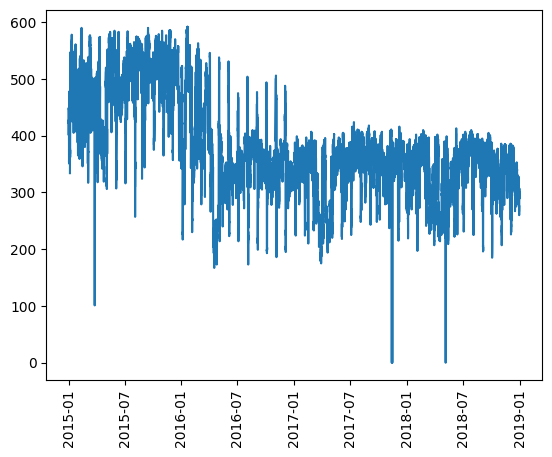

In [ ]:
# We need to split our sequence into smaller mini-sequences. What length should we use?
x = df["time"]
y = df["generation biomass"]
plt.plot(x, y)
plt.tick_params(axis='x', labelrotation=90)
plt.show()

In [ ]:
# We split our data into week samples
features = df.drop(columns="time").to_numpy()
# Obsevations every hour so 7 days * 24 hours = 168 obs per mini-sequence
n_obs_per_sequence = 168
n = features.shape[0] // n_obs_per_sequence
features = features[:(n*n_obs_per_sequence),:].reshape(-1, n_obs_per_sequence, features.shape[1])
# Shape is now (# examples, # time points, # features)
print(features.shape)

(208, 168, 3)


In [ ]:
# Train DGAN model
model = DGAN(DGANConfig(
    max_sequence_len=features.shape[1],
    sample_len=28,
    batch_size=min(1000, features.shape[0]),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=5000,
))

model.train_numpy(
    features,
    feature_types=[OutputType.CONTINUOUS] * features.shape[2],
)

# Generate synthetic data
_, synthetic_features = model.generate_numpy(1000)

2023-05-02 12:56:18,982 : MainThread : WARNING : There are 1 examples that have too many nan values in numeric features, accounting for 0.4807692307692308% of all examples. These invalid examples will be omitted from training.
2023-05-02 12:56:18,985 : MainThread : INFO : epoch: 0
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
/opt/anaconda3/envs/CRP/lib/python3.10/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
2023-05-02 12:56:19,086 : MainThread : INFO : epoch: 1
20

In [ ]:
n_samples, n_obs_per_sequence, n_features = synthetic_features.shape
print(f"We obtain a synthetic dataset with {n_samples} samples of length {n_obs_per_sequence} each for {n_features} features")

We obtain a synthetic dataset with 1000 samples of length 168 each for 3 features


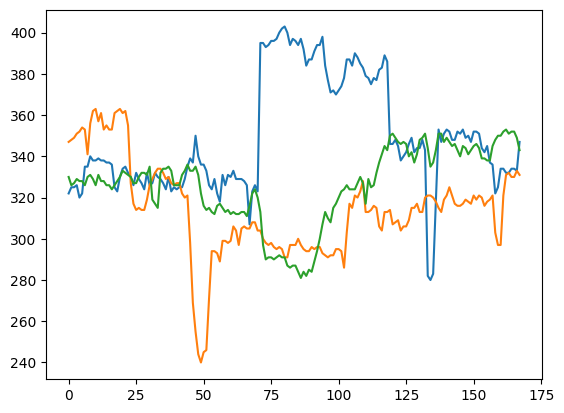

In [ ]:
# Plot of original TS of one week
n_examples = 3
offset = 70
sample_example = features[offset:offset+n_examples]
biomass_original = sample_example[:, :,0]
for i in range(n_examples):
    plt.plot(biomass_original[i])
plt.show()

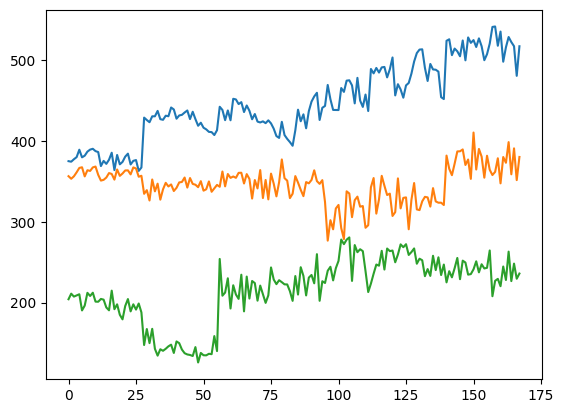

In [ ]:
# Plot of synthetic TS of one week
n_examples = 3
sample_example = synthetic_features[0:n_examples]
biomass_example = sample_example[:, :,0]
for i in range(n_examples):
    plt.plot(biomass_example[i])
plt.show()

##### Second try

In [73]:
df = datasets["energy_dataset"].iloc[:1000]

In [74]:
# Switch the shape of the dataframe to long format
gen_columns = list(filter(lambda x: "generation" in x, df.columns))
df_long = df.melt(["time"], gen_columns)
df_long.columns = ["time","energy_source", "value"]

# Clean time and energy_source column
df_long["time"] = pd.to_datetime(df_long["time"], utc = True)
df_long["energy_source"] = df_long["energy_source"].apply(lambda x: x.replace("generation ", ""))

In [75]:
df_long

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,time,energy_source,value
0,2014-12-31 23:00:00+00:00,biomass,447.0
1,2015-01-01 00:00:00+00:00,biomass,449.0
2,2015-01-01 01:00:00+00:00,biomass,448.0
3,2015-01-01 02:00:00+00:00,biomass,438.0
4,2015-01-01 03:00:00+00:00,biomass,428.0
...,...,...,...
20995,2015-02-11 10:00:00+00:00,wind onshore,9396.0
20996,2015-02-11 11:00:00+00:00,wind onshore,8364.0
20997,2015-02-11 12:00:00+00:00,wind onshore,7684.0
20998,2015-02-11 13:00:00+00:00,wind onshore,6762.0


In [76]:
df_long.time

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       2014-12-31 23:00:00+00:00
1       2015-01-01 00:00:00+00:00
2       2015-01-01 01:00:00+00:00
3       2015-01-01 02:00:00+00:00
4       2015-01-01 03:00:00+00:00
                   ...           
20995   2015-02-11 10:00:00+00:00
20996   2015-02-11 11:00:00+00:00
20997   2015-02-11 12:00:00+00:00
20998   2015-02-11 13:00:00+00:00
20999   2015-02-11 14:00:00+00:00
Name: time, Length: 21000, dtype: datetime64[ns, UTC]

In [77]:

# Metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_long)

metadata.update_column(
    "energy_source",
    sdtype='id',
)
metadata.set_sequence_key("energy_source")
metadata.update_column(
    column_name='time',
    sdtype='datetime',
    datetime_format='%Y-%m-%d %H:%M:%S')
metadata.set_sequence_index(column_name='time')

metadata

{
    "columns": {
        "time": {
            "sdtype": "datetime",
            "datetime_format": "%Y-%m-%d %H:%M:%S"
        },
        "energy_source": {
            "sdtype": "id"
        },
        "value": {
            "sdtype": "numerical"
        }
    },
    "sequence_key": "energy_source",
    "sequence_index": "time",
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [81]:
# Step 1: Create the synthesizer
synthesizer = PARSynthesizer(metadata, verbose = True, epochs = 100, cuda = True)

# Step 2: Train the synthesizer
synthesizer.fit(df_long)

# Step 3: Generate synthetic data.
synthetic_data = synthesizer.sample(num_sequences=1)

Epoch 100 | Loss -65.61166381835938: 100%|██████████| 100/100 [02:55<00:00,  1.76s/it]
100%|██████████| 3/3 [00:49<00:00, 16.42s/it]
/usr/local/lib/python3.10/dist-packages/sdv/data_processing/data_processor.py:751: FutureWarning: Using .astype to convert from timezone-naive dtype to timezone-aware dtype is deprecated and will raise in a future version.  Use ser.dt.tz_localize instead.
  reversed_data[column_name] = column_data[column_data.notna()].astype(dtype)


In [90]:
# Analyzing NA values
epochs_list = [5, 10, 50, 100, 200]
na_values = []
for epochs in epochs_list:
    # Step 1: Create the synthesizer
    synthesizer = PARSynthesizer(metadata, verbose = True, epochs = epochs, cuda = True)
    # Step 2: Train the synthesizer
    synthesizer.fit(df_long)
    # Step 3: Generate synthetic data.
    synthetic_data = synthesizer.sample(num_sequences=1)
    na_count = synthetic_data.isna().sum()["value"]
    na_values.append(na_count)

Epoch 5 | Loss 62.3714485168457: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]
100%|██████████| 1/1 [00:15<00:00, 15.73s/it]
/usr/local/lib/python3.10/dist-packages/sdv/data_processing/data_processor.py:751: FutureWarning: Using .astype to convert from timezone-naive dtype to timezone-aware dtype is deprecated and will raise in a future version.  Use ser.dt.tz_localize instead.
  reversed_data[column_name] = column_data[column_data.notna()].astype(dtype)
Epoch 10 | Loss 61.97212600708008: 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]
100%|██████████| 1/1 [00:14<00:00, 14.87s/it]
/usr/local/lib/python3.10/dist-packages/sdv/data_processing/data_processor.py:751: FutureWarning: Using .astype to convert from timezone-naive dtype to timezone-aware dtype is deprecated and will raise in a future version.  Use ser.dt.tz_localize instead.
  reversed_data[column_name] = column_data[column_data.notna()].astype(dtype)
Epoch 50 | Loss -14.952857971191406: 100%|██████████| 50/50 [01:43<00:00,  2.0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


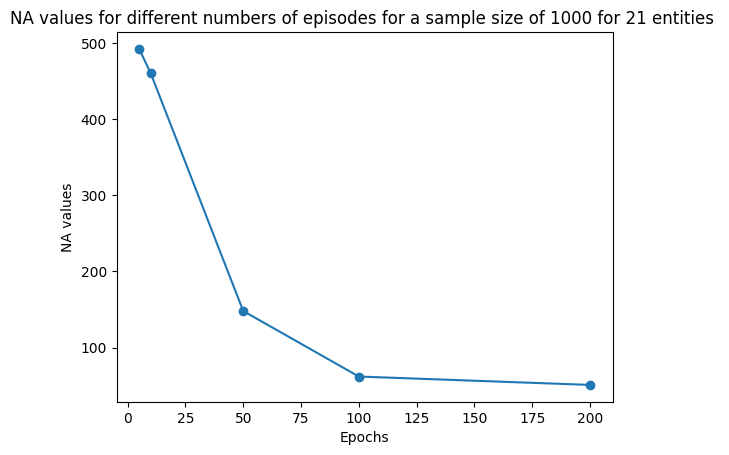

In [97]:
# Plot NA values
plt.plot(epochs_list, na_values, marker = "o")
plt.title("NA values for different numbers of episodes for a sample size of 1000 for 21 entities ")
plt.xlabel("Epochs")
plt.ylabel("NA values")
plt.show()

In [117]:
synthetic_data_plot = synthesizer.sample(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 5/5 [00:58<00:00, 11.62s/it]
/usr/local/lib/python3.10/dist-packages/sdv/data_processing/data_processor.py:751: FutureWarning: Using .astype to convert from timezone-naive dtype to timezone-aware dtype is deprecated and will raise in a future version.  Use ser.dt.tz_localize instead.
  reversed_data[column_name] = column_data[column_data.notna()].astype(dtype)


In [118]:
synthetic_data_plot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,time,energy_source,value
0,2014-12-31 23:00:00+00:00,00001,NaN
1,2015-01-01 00:00:00+00:00,00001,1243.329159
2,2015-01-01 01:00:00+00:00,00001,1298.494627
3,2015-01-01 02:00:00+00:00,00001,1521.884217
4,2015-01-01 03:00:00+00:00,00001,1411.164912
...,...,...,...
4995,2015-02-11 10:00:00+00:00,0000d,1945.496396
4996,2015-02-11 11:00:00+00:00,0000d,NaN
4997,2015-02-11 12:00:00+00:00,0000d,1519.540397
4998,2015-02-11 13:00:00+00:00,0000d,1907.005146


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


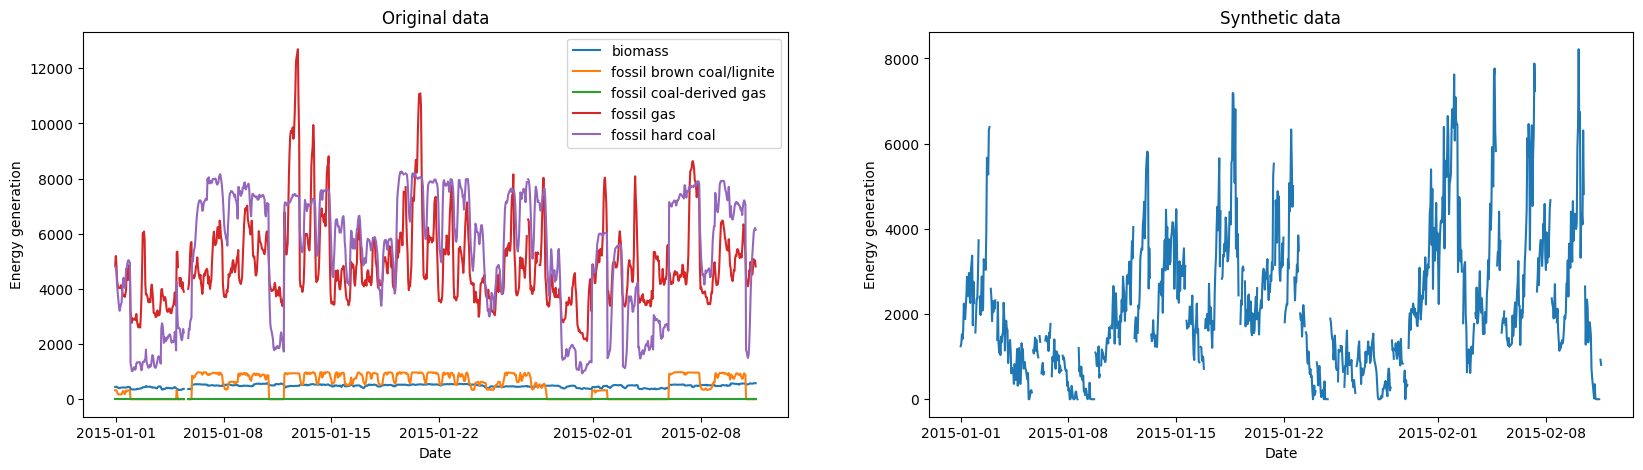

In [123]:
# Plot original data vs. synthetic data
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
by_source = df_long.groupby('energy_source')
MAX_COUNT = [5, 1]
c = 0

for i, df in enumerate([df_long, synthetic_data_plot]):
    by_source = df.groupby('energy_source')
    c = 0
    for name, group in by_source:
        if i == 1:
            name = None
        if c == MAX_COUNT[i]:
            break
        c += 1
        axs[i].plot(group['time'], group['value'], label=name)
    if i == 0:
        axs[i].legend()
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Energy generation")

axs[0].set_title("Original data")
axs[1].set_title("Synthetic data")
plt.show()